In [1]:
import os.path as ospath
import numpy as np
import torch # pytorch
import torch.nn.functional as F # pytorch NN functional module
from torch_geometric.utils import remove_self_loops
from torch_geometric.loader import DataLoader
import pickle

Please note that the cached graphs and values with this ipynb could be in eV, but the they will be shown in kcal/mol if again run. 

In [2]:
import torch_geometric.transforms as T
from torch_geometric.datasets import QM9

__file__ = 'dsgdb9nsd.xyz' # an example of a file name to extract the path of the QM dataset
path = ospath.join(ospath.dirname(ospath.realpath(__file__)), '..', 'data', 'QM9')
#transform = T.Compose([MyTransform(), Complete(), T.Distance(norm=False)])
'''
T.compose: Composes several transforms together.
PARAMETERS:
-----------
transforms (List[Callable]) – List of transforms to compose.
'''
#dataset = QM9(path, transform=transform)
dataset = QM9(path)

In [3]:
indices = np.random.RandomState(seed=42).permutation(len(dataset))

# OR
#with open('indices.pkl','rb') as f:
#    indices = pickle.load(f)

In [6]:
# Split datasets
batchsize = 128
target = 15

test_dataset = dataset[indices[0:10000]]
val_dataset = dataset[indices[10000:20000]]
train_dataset = dataset[indices[20000:]]

In [7]:
tr_sum = 0
std_sum = 0
for i in range(len(train_dataset)):
     tr_sum += train_dataset[i].y[:,target]
tr_mean = (tr_sum / len(train_dataset)).item()


for i in range(len(train_dataset)):
    std_sum += (train_dataset[i].y[:,target] - tr_mean) ** 2
tr_std = np.sqrt(std_sum / len(train_dataset)).item()

In [8]:
for i in range(len(train_dataset)):
    train_dataset[i].y[:,target] = (train_dataset[i].y[:,target] - tr_mean) / tr_std

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

# About made dataset using pytorch-geometric
x (Tensor, optional): Node feature matrix with shape :obj:`[num_nodes,
            num_node_features]  
  
edge_index (LongTensor, optional): Graph connectivity in COO format
            with shape :obj:`[2, num_edges]  
    
edge_attr (Tensor, optional): Edge feature matrix with shape
            :obj:`[num_edges, num_edge_features]`. (default: :obj:`None`)  
            
y (Tensor, optional): Graph-level or node-level ground-truth labels
            with arbitrary shape. (default: :obj:`None`)
            
pos (Tensor, optional): Node position matrix with shape
            :obj:`[num_nodes, num_dimensions]`. (default: :obj:`None`)  
            
https://www.youtube.com/watch?v=Vz5bT8Xw6Dc  

https://www.youtube.com/watch?v=Q5T-JdyVCfs

In [10]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of type of regression targets: {dataset.num_classes}')

Dataset: QM9(130831):
Number of graphs: 130831
Number of features: 11
Number of type of regression targets: 19


#### This dataset holds 130831 graphs and  each node in this dataset is assigned a 34-dimensional feature vector.

The edge_index property holds the information about the graph connectivity, i.e., a tuple of source and destination node indices for each edge.

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        #torch.manual_seed(12345)
        self.conv1 = GCNConv(in_channels=dataset.num_features, out_channels=hidden_channels)
        self.conv2 = GCNConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.conv3 = GCNConv(in_channels=hidden_channels, out_channels=hidden_channels)
        
        self.lin1 = nn.Linear(in_features=hidden_channels, out_features=64)
        self.lin2 = nn.Linear(in_features=64, out_features=1)
        
    def forward(self, x, edge_index, batch):
        
        # 1. node embeddings
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        # Linear layers
        
        x = F.relu(self.lin1(x))
        F.dropout(x, p=0.5, training=True)
        x = self.lin2(x)
        return x.view(-1)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=128).to(device)
print(model)

GCN(
  (conv1): GCNConv(11, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (lin1): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)


In [12]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, 
                                                       patience=5, min_lr=0.00001)
criterian = nn.L1Loss()

current_epoch = 0 

training_size = len(train_loader.dataset)
validation_size = len(val_loader.dataset)
loss_epoch_trn_list, loss_epoch_val_list, MAE_epoch_val_list = [], [], [] # loss storage lists

for epoch in range(300):
    current_epoch = epoch + 1
    running_trn_loss, running_batch_trn_loss = 0.0 , 0.0
    print(f"\nEpoch {epoch+1}\n-------------------------------")
  
  #__________________#
  # TRAINING
  #__________________#

    model.train()

    for dt in train_loader:
        
        dt = dt.to(device)
        # Single forward pass 
        pred = model(dt.x, dt.edge_index, dt.batch)
        
        # Compute the loss
        #loss = F.mse_loss(pred, dt.y[:,target])
        loss = criterian(pred, dt.y[:,target])
        
        # backpropogation 
        loss.backward() # Derive gradients
        optimizer.step() # Update parameters based on gradients
        optimizer.zero_grad() # zeroes the gradients
    
        # statistics
        running_trn_loss += loss.item()
        #running_batch_trn_loss += loss.item() 
        
    # cummulative training loss after each epoch
    epoch_mean_trn_loss = running_trn_loss / training_size
    loss_epoch_trn_list.append(epoch_mean_trn_loss)
    print(f"Training MAE loss: {loss_epoch_trn_list[-1]:>7f}")
  
  #_____________#
  # VALIDATION
  #_____________#

    model.eval()
    running_val_loss, error = 0, 0
  
    with torch.no_grad():
        for dv in val_loader:
            dv = dv.to(device)
            pred = model(dv.x, dv.edge_index, dv.batch) 
            #val_loss = F.mse_loss(pred, dv.y[:,target])
            #val_loss = criterian(pred, dv.y[:,target])
            #running_val_loss += val_loss.item()
            error += (pred * tr_std + tr_mean - dv.y[:,target]).abs().sum().item()  # MAE

    scheduler.step(error)
    MAE_epoch_val_list.append(error / len(val_dataset))
    #loss_epoch_val_list.append(running_val_loss/ len(val_dataset)) # append to list
    print(f"validation MAE: {running_val_loss / len(val_dataset):>7f}")
    print(f'MAE in validation set: {error / len(val_dataset):>7f}')
            

    #saving model for minimum validation loss
    if MAE_epoch_val_list[-1] <= min(MAE_epoch_val_list):
        print("model saved\n")
        torch.save(model, './best_128_3GCN.pth')


Epoch 1
-------------------------------
Training MAE loss: 0.002178
validation MAE: 0.558787
MAE in validation set: 2.289270
model saved


Epoch 2
-------------------------------
Training MAE loss: 0.001904
validation MAE: 0.558831
MAE in validation set: 2.271976
model saved


Epoch 3
-------------------------------
Training MAE loss: 0.001889
validation MAE: 0.558873
MAE in validation set: 2.255318
model saved


Epoch 4
-------------------------------
Training MAE loss: 0.001861
validation MAE: 0.558793
MAE in validation set: 2.219398
model saved


Epoch 5
-------------------------------
Training MAE loss: 0.001836
validation MAE: 0.558304
MAE in validation set: 2.182632
model saved


Epoch 6
-------------------------------
Training MAE loss: 0.001811
validation MAE: 0.558177
MAE in validation set: 2.233130

Epoch 7
-------------------------------
Training MAE loss: 0.001795
validation MAE: 0.558489
MAE in validation set: 2.124719
model saved


Epoch 8
-------------------------------

validation MAE: 0.559010
MAE in validation set: 1.246779
model saved


Epoch 63
-------------------------------
Training MAE loss: 0.001073
validation MAE: 0.559027
MAE in validation set: 1.244884
model saved


Epoch 64
-------------------------------
Training MAE loss: 0.001030
validation MAE: 0.559281
MAE in validation set: 1.224769
model saved


Epoch 65
-------------------------------
Training MAE loss: 0.001033
validation MAE: 0.559270
MAE in validation set: 1.246622

Epoch 66
-------------------------------
Training MAE loss: 0.000990
validation MAE: 0.558961
MAE in validation set: 1.175698
model saved


Epoch 67
-------------------------------
Training MAE loss: 0.000963
validation MAE: 0.559160
MAE in validation set: 1.134344
model saved


Epoch 68
-------------------------------
Training MAE loss: 0.000942
validation MAE: 0.559334
MAE in validation set: 1.109392
model saved


Epoch 69
-------------------------------
Training MAE loss: 0.000926
validation MAE: 0.558861
MAE in v

Training MAE loss: 0.000685
validation MAE: 0.559269
MAE in validation set: 0.838419
model saved


Epoch 126
-------------------------------
Training MAE loss: 0.000681
validation MAE: 0.559413
MAE in validation set: 0.889984

Epoch 127
-------------------------------
Training MAE loss: 0.000681
validation MAE: 0.559175
MAE in validation set: 0.892280

Epoch 128
-------------------------------
Training MAE loss: 0.000683
validation MAE: 0.559537
MAE in validation set: 0.934619

Epoch 129
-------------------------------
Training MAE loss: 0.000680
validation MAE: 0.559281
MAE in validation set: 0.854883

Epoch 130
-------------------------------
Training MAE loss: 0.000684
validation MAE: 0.559200
MAE in validation set: 0.846564

Epoch 131
-------------------------------
Training MAE loss: 0.000680
validation MAE: 0.559424
MAE in validation set: 0.897176

Epoch 132
-------------------------------
Training MAE loss: 0.000667
validation MAE: 0.559191
MAE in validation set: 0.844053

Epoch

Training MAE loss: 0.000631
validation MAE: 0.559366
MAE in validation set: 0.798248

Epoch 189
-------------------------------
Training MAE loss: 0.000631
validation MAE: 0.559234
MAE in validation set: 0.800003

Epoch 190
-------------------------------
Training MAE loss: 0.000630
validation MAE: 0.559272
MAE in validation set: 0.793970
model saved


Epoch 191
-------------------------------
Training MAE loss: 0.000631
validation MAE: 0.559312
MAE in validation set: 0.793193
model saved


Epoch 192
-------------------------------
Training MAE loss: 0.000630
validation MAE: 0.559286
MAE in validation set: 0.798065

Epoch 193
-------------------------------
Training MAE loss: 0.000630
validation MAE: 0.559303
MAE in validation set: 0.794382

Epoch 194
-------------------------------
Training MAE loss: 0.000630
validation MAE: 0.559270
MAE in validation set: 0.793203

Epoch 195
-------------------------------
Training MAE loss: 0.000630
validation MAE: 0.559318
MAE in validation set: 0.

Training MAE loss: 0.000620
validation MAE: 0.559305
MAE in validation set: 0.783819
model saved


Epoch 252
-------------------------------
Training MAE loss: 0.000620
validation MAE: 0.559303
MAE in validation set: 0.784936

Epoch 253
-------------------------------
Training MAE loss: 0.000619
validation MAE: 0.559328
MAE in validation set: 0.784116

Epoch 254
-------------------------------
Training MAE loss: 0.000620
validation MAE: 0.559301
MAE in validation set: 0.785658

Epoch 255
-------------------------------
Training MAE loss: 0.000619
validation MAE: 0.559321
MAE in validation set: 0.783943

Epoch 256
-------------------------------
Training MAE loss: 0.000620
validation MAE: 0.559317
MAE in validation set: 0.783422
model saved


Epoch 257
-------------------------------
Training MAE loss: 0.000619
validation MAE: 0.559300
MAE in validation set: 0.783690

Epoch 258
-------------------------------
Training MAE loss: 0.000619
validation MAE: 0.559312
MAE in validation set: 0.

# Error visualisation

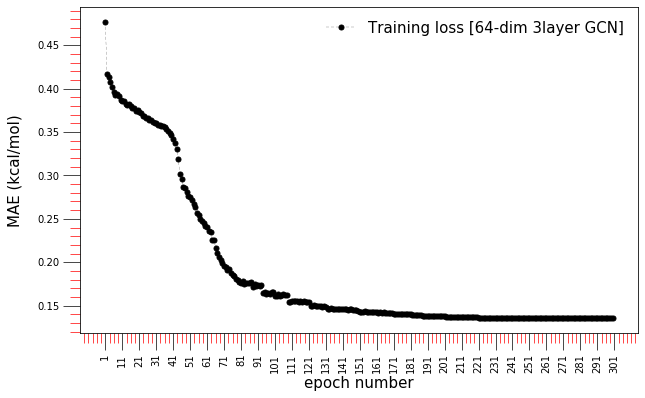

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
fig,ax = plt.subplots(figsize=(10, 6))
x_points = np.arange(1, epoch+2, 1 )
x_points_ = np.arange(1, epoch+3, 10 )
ax.set_xticks(x_points_)
plt.xticks(rotation=90)
ax.set_xlabel('epoch number',fontsize=15, labelpad =3)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', width=0.7,length=17,direction="out" , labelleft=True )
ax.tick_params(which='minor', width=0.7, length=10, color='r', direction="out")
ax.set_ylabel('MAE (kcal/mol)',fontsize=15, labelpad=15)
ax.plot(x_points, np.array(loss_epoch_trn_list) * tr_std * 23.06 , color = 'black', marker='o', markersize=5 , linestyle='dashed', dashes=(15, 10),linewidth=0.2) 
# 23.06 1ev = 23.06 kcal/mol
ax.legend(['Training loss [128-dim 3layer GCN]'], loc='best', fontsize=15, frameon=False)
plt.savefig("H_128_3Layer_trainingGCN.png")
plt.show()
# values in the cached graph attached with this ipynb are in eV but will be shown in kcal/mol if run again.

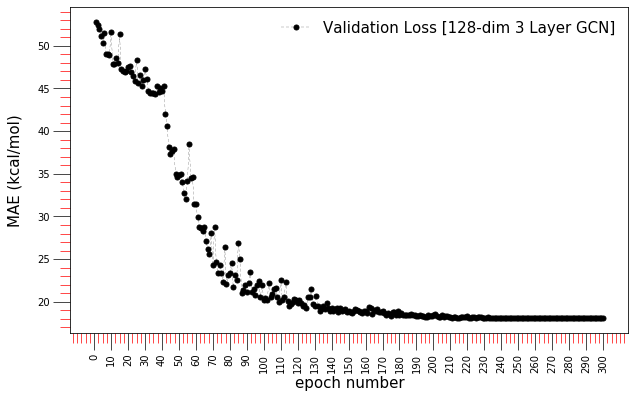

In [19]:
fig,ax = plt.subplots(figsize=(10, 6))
x_points = np.arange(1, 299+2, 1 )
x_points_ = np.arange(0, 299+3, 10 )
ax.set_xticks(x_points_)
ax.set_xlabel('epoch number',fontsize=15, labelpad =3)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.xticks(rotation=90)
ax.tick_params(which='major', width=0.7,length=17,direction="out" , labelleft=True )
ax.tick_params(which='minor', width=0.7, length=10, color='r', direction="out")
ax.set_ylabel('MAE (kcal/mol)',fontsize=15, labelpad=15)
ax.plot(x_points, np.array(MAE_epoch_val_list) * 23.06 , color = 'black', marker='o', markersize=5 , linestyle='dashed', dashes=(15, 10),linewidth=0.2) 
#ax.plot(x_points, loss_epoch_val_list , color = 'black', marker='v', markersize=5 , linestyle='solid', linewidth=0.2) 
ax.legend(['Validation Loss [128-dim 3 Layer GCN]'], loc='best', fontsize=15, frameon=False)
plt.savefig("MAE_128_3LayerGCN_validation.png")
plt.show()

In [22]:
# Validation error
min(MAE_epoch_val_list) * 23.06 

18.050462362976074

# Load Network and generalisation error on test data

In [23]:
#load model and continue training
PATH = './best_128_3GCN.pth'
our_saved_model = torch.load(PATH)

In [24]:
error = 0
actual_values = []
predicted_values = []
our_saved_model.eval()
with torch.no_grad():
    for dtest in test_loader:
        dtest = dtest.to(device)
        pred = model(dtest.x, dtest.edge_index, dtest.batch)
        predicted_values.append(pred * tr_std + tr_mean)
        error += (pred * tr_std + tr_mean - dtest.y[:,target]).abs().sum().item()  # MAE
        actual_values. append(dtest.y[:,target])
    mae_test_set = error / len(test_loader.dataset) * 23.06
    print(f"MAE Test Set: {mae_test_set:>7f}")
    
# MAE Test Set: 2.039291 64 Drop 100 epoch 64



MAE Test Set: 18.757790


In [30]:
m = []
for each in actual_values:
    each = m.append(each.tolist())
actual_ = np.array([item for sublist in m for item in sublist])  * 23.06

n = []
for each in predicted_values:
    each = n.append(each.tolist())
pred_ = np.array([item for sublist in n for item in sublist]) * 23.06

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(actual_, pred_))

In [31]:
# utility Functions
def plot_pred_actual(y_true, y_predict,r2, mae, test_num_atoms, rmse):
    """ Plots Predicted energy vs actual energy for input data
    
    Parameters
    ----------
    y_true: 1-d ndarray
            Actual energy
    y_predict: 1-d ndarray
               prediction energy
    r2: float
        r2_score value
    mae : float
          MAE value
    """
    
    x_min = np.min(np.concatenate((y_true , y_predict)))
    x_max = np.max(np.concatenate((y_true, y_predict)))
    line = np.linspace(x_min, x_max, 10)
    plt.plot(line, line,  c='r')

    ax = plt.subplot(1,1,1)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([x_min, x_max])
    im = ax.scatter(y_predict , y_true , marker='.', c=test_num_atoms)
    plt.xlabel('Actual energy (kcal/mol)')
    plt.ylabel('Predicted energy (kcal/mol)')
    cbar = plt.colorbar(im)
    cbar.ax.set_ylabel('# of atoms in a molecule', rotation=90)
    plt.title(f'3-Layer GCN 128 hidden features \nr2_score :{r2:5.3f}, MAE: {mae:5.3f}, RMSE:{rmse:5.3f}')
    plt.savefig('GCN_300_128_epoch_pred_vs_actual.png')
    plt.show()

In [20]:
num_atoms = []
for i in range(len(dataset)):
    num_atoms.append(dataset[i].pos.shape[0])
    
num_atoms = np.array(num_atoms)
train_num_atoms = num_atoms[indices[20000:]]
val_num_atoms = num_atoms[indices[10000:20000]]
test_num_atoms = num_atoms[indices[0:10000]]

dsgdb9nsd.xyz:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


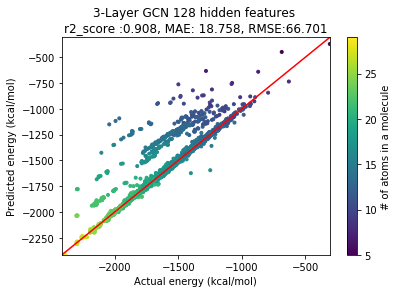

In [32]:
r2 = r2_score(actual_, pred_)
plot_pred_actual(actual_, pred_, r2, mae_test_set, test_num_atoms, rmse)